In [3]:
import numpy as np
import rasterio
import rasterio.mask
from rasterio.windows import Window
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.model_selection import train_test_split
import torch
import matplotlib as mpl
from rasterio.warp import calculate_default_transform, reproject, Resampling
import os
from rasterio.merge import merge

In [10]:
# function to load biomass data
def merge_mosaic(year=None, resolution=30, dst_crs="EPSG:6933"):
    
    path_bio = f"../data/raw/biomass/amazonia/{resolution}m/deforestation/" 
    path_bios = [path_bio + name for name in os.listdir(path_bio) if f"-{year}-" in name]
    
    src_files_to_mosaic = []
    for fp in path_bios:
        src = rasterio.open(fp)
        src_files_to_mosaic.append(src)

    mosaic, out_trans = merge(src_files_to_mosaic)
    mosaic = (mosaic/100).astype(np.uint8)
    
    out_meta = src.meta.copy()
    
    # Get bounds of the merged mosaic
    out_height, out_width = mosaic.shape[1], mosaic.shape[2]
    out_ulx, out_uly = out_trans * (0, 0)
    out_lrx, out_lry = out_trans * (out_width, out_height)
    bounds = (out_ulx, out_lry, out_lrx, out_uly)

    out_meta.update({"driver": "GTiff", 
                     "height": mosaic.shape[1],
                     "width": mosaic.shape[2],
                     "transform": out_trans
                     })
    
    transform, width, height = calculate_default_transform(
            src.crs, dst_crs, out_meta['width'], out_meta['height'], *bounds)
    
    out_meta.update({
        "crs": dst_crs,
        "transform": transform,
        "width": width,
        "height": height
    })
    
    path_out = f"../data/processed/{30}m/deforestation/"  + f"deforestation_{year}.tif"
    with rasterio.open(path_out, "w", **out_meta, compress="DEFLATE") as dest:
        reproject(
            source=mosaic[0],
            destination=rasterio.band(dest, 1),
            src_transform=out_trans,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest)
            
merge_mosaic(2019)

In [23]:
import rasterio
from rasterio.windows import Window

path = f"../data/processed/{30}m/deforestation/"  + f"deforestation_{2019}.tif"
# Open the mosaic file
with rasterio.open(path) as src:
    # Define the window
    x, y, input_px = 10000, 10000, 4000
    window = Window(x + int(input_px/2), y + int(input_px/2), input_px, input_px)

    # Read the data from the window
    data = src.read(window=window)
    data = data.squeeze()


In [24]:
data.shape

(4000, 4000)

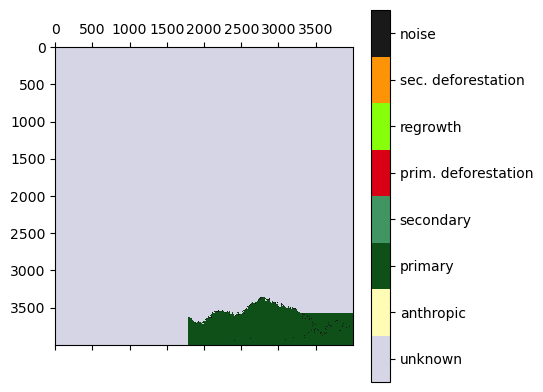

In [25]:
cmap = colors.ListedColormap(['#D5D5E5', '#FFFCB5','#0F5018', '#409562', '#D90016', '#87FF0A', '#FD9407', '#191919'])
mat = plt.matshow(data,cmap=cmap,vmin = -.5, vmax = 7.5)
cax = plt.colorbar(mat, ticks=np.arange(0,8))
cax.ax.set_yticklabels(['unknown', 'anthropic', 'primary', 'secondary', 'prim. deforestation', 'regrowth', 'sec. deforestation', 'noise'])
plt.show()

In [21]:
# area_amazonia = 4196943 * 100 # reported online
area_amazonia = 421544315 # calculated with ESG
observed_px = np.count_nonzero(data != 0)
adapted_px_dim = np.sqrt(area_amazonia * 10000 / observed_px)
np.count_nonzero(data == 4) * adapted_px_dim**2 / 10000 # reported: 740159.18 ha (2019) vs 740822

740822.7306206718